# In this notebook, we are going to implement CNN model to analysis the data
## https://en.wikipedia.org/wiki/Multilayer_perceptron


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
906   HAM_0001991  ISIC_0028347  bkl  consensus  80.0    male   
8841  HAM_0006596  ISIC_0031081   nv      histo  35.0    male   
6205  HAM_0001075  ISIC_0028743   nv  follow_up  30.0  female   
1226  HAM_0003832  ISIC_0024586  mel      histo  60.0  female   
3846  HAM_0007201  ISIC_0026208   nv  follow_up  50.0    male   

         localization  label  
906   upper extremity      2  
8841             back      5  
6205             back      5  
1226  lower extremity      4  
3846  lower extremity      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [33]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])


total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [6]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

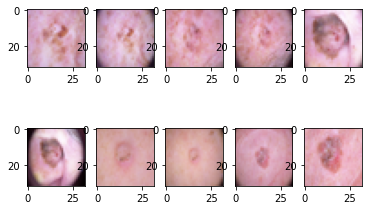

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [51]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
#data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.20,random_state=random.randint(1,99),stratify=label_to_one_hot)

In [52]:
#setup CNN model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPooling2D
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#CNN layer 1:
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#CNN layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#CNN layer 3
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#CNN layer 4
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


#Flatten layer
model.add(Flatten())
model.add(Dropout(0.15))

#hidden layer 1
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.15))

#hidden layer 2
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.15))

#output layer
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_34 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_35 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)       

In [53]:
# Train

batch_size = 512
epochs = 50

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

Epoch 1/50
13/13 - 11s - loss: 1.8199 - acc: 0.6358 - val_loss: 1.5051 - val_acc: 0.6794
Epoch 2/50
13/13 - 11s - loss: 1.5027 - acc: 0.6670 - val_loss: 1.1110 - val_acc: 0.6794
Epoch 3/50
13/13 - 11s - loss: 1.3264 - acc: 0.6670 - val_loss: 1.0753 - val_acc: 0.6794
Epoch 4/50
13/13 - 10s - loss: 1.2280 - acc: 0.6670 - val_loss: 1.0102 - val_acc: 0.6794
Epoch 5/50
13/13 - 10s - loss: 1.1985 - acc: 0.6670 - val_loss: 1.0250 - val_acc: 0.6794
Epoch 6/50
13/13 - 10s - loss: 1.1697 - acc: 0.6670 - val_loss: 1.0060 - val_acc: 0.6794
Epoch 7/50
13/13 - 10s - loss: 1.1411 - acc: 0.6670 - val_loss: 0.9887 - val_acc: 0.6794
Epoch 8/50
13/13 - 10s - loss: 1.1056 - acc: 0.6775 - val_loss: 0.9393 - val_acc: 0.6731
Epoch 9/50
13/13 - 10s - loss: 1.0945 - acc: 0.6839 - val_loss: 0.9442 - val_acc: 0.6744
Epoch 10/50
13/13 - 10s - loss: 1.0896 - acc: 0.6862 - val_loss: 0.9473 - val_acc: 0.6856
Epoch 11/50
13/13 - 10s - loss: 1.0863 - acc: 0.6861 - val_loss: 0.9073 - val_acc: 0.6918
Epoch 12/50
13/13 -

In [29]:
# Train without class weight


batch_size = 256
epochs = 50

train_history_class = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2)

Epoch 1/50
26/26 - 9s - loss: 1.2328 - acc: 0.6453 - val_loss: 1.2400 - val_acc: 0.6631
Epoch 2/50
26/26 - 9s - loss: 1.0347 - acc: 0.6711 - val_loss: 1.0994 - val_acc: 0.6631
Epoch 3/50
26/26 - 10s - loss: 1.0108 - acc: 0.6711 - val_loss: 1.0500 - val_acc: 0.6631
Epoch 4/50
26/26 - 9s - loss: 0.9941 - acc: 0.6711 - val_loss: 1.0058 - val_acc: 0.6631
Epoch 5/50
26/26 - 10s - loss: 0.9469 - acc: 0.6745 - val_loss: 1.0959 - val_acc: 0.6719
Epoch 6/50
26/26 - 10s - loss: 0.9483 - acc: 0.6819 - val_loss: 0.9849 - val_acc: 0.6669
Epoch 7/50
26/26 - 9s - loss: 0.9139 - acc: 0.6886 - val_loss: 0.9134 - val_acc: 0.6912
Epoch 8/50
26/26 - 9s - loss: 0.9174 - acc: 0.6886 - val_loss: 0.9371 - val_acc: 0.6943
Epoch 9/50
26/26 - 10s - loss: 0.8923 - acc: 0.6903 - val_loss: 0.9256 - val_acc: 0.6725
Epoch 10/50
26/26 - 10s - loss: 0.9025 - acc: 0.6864 - val_loss: 0.9619 - val_acc: 0.6887
Epoch 11/50
26/26 - 10s - loss: 0.8812 - acc: 0.6887 - val_loss: 0.8965 - val_acc: 0.6868
Epoch 12/50
26/26 - 10s 

In [38]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

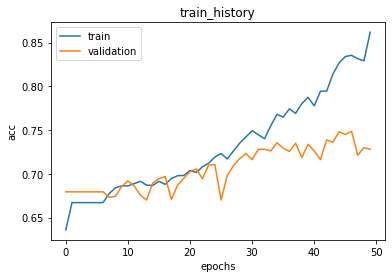

In [54]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

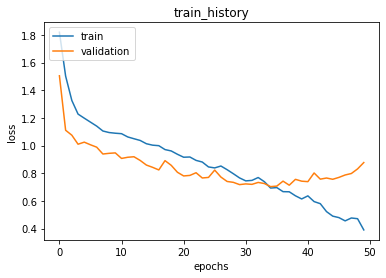

In [55]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [56]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 16ms/step - loss: 0.8835 - acc: 0.7474

In [57]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['label'],colnames=['predict']))


[4 5 2 ... 3 5 5]
predict   0   1    2   3   4     5   6
label                                 
0        11  13   21   8   1    11   0
1         9  50   16   7   2    18   1
2         6  11  123   7   5    66   2
3         0   4    3  12   0     3   1
4         1  11   62   2  40   106   1
5         2  10   65   8  11  1242   3
6         0   4    0   0   0     5  19
predict  akiex  bcc  bkl  df  mel    nv  vasc
label                                        
akiex       11   13   21   8    1    11     0
bcc          9   50   16   7    2    18     1
bkl          6   11  123   7    5    66     2
df           0    4    3  12    0     3     1
mel          1   11   62   2   40   106     1
nv           2   10   65   8   11  1242     3
vasc         0    4    0   0    0     5    19
